In [14]:
# If you are running the notebook in COLAB run the following line of code
# !pip install fastai==2.0.13

In [15]:
'''
Useful links:
Data preprocessing: https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis
Train ULMFit in IMDB: https://course.fast.ai/videos/?lesson=8
'''

'\nUseful links:\nData preprocessing: https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis\nTrain ULMFit in IMDB: https://course.fast.ai/videos/?lesson=8\n'

In [235]:
import seaborn as sns

In [16]:
from fastai.text.all import *
import torch
import re
import os
from os import listdir
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,HTML

In [17]:
url = 'https://raw.githubusercontent.com/arnaujc91/ULMFit/master/data/Tweets.csv'
tweets = pd.read_csv(url)
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [18]:
display(HTML(tweets.to_html(columns=['text'], index=False,header=None, max_rows=20)))

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
"@virginamerica Well, I didn't…but NOW I DO! :-D"
"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
...


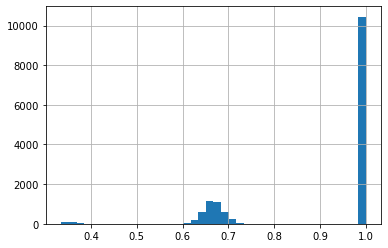

In [19]:
tweets.airline_sentiment_confidence.hist(bins=40)

In [20]:
tweets.airline_sentiment.value_counts()/len(tweets)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [21]:
tweets.negativereason_gold.value_counts()

Customer Service Issue                      12
Late Flight                                  4
Cancelled Flight                             3
Can't Tell                                   3
Cancelled Flight\nCustomer Service Issue     2
Late Flight\nFlight Attendant Complaints     1
Customer Service Issue\nLost Luggage         1
Late Flight\nCancelled Flight                1
Flight Attendant Complaints                  1
Lost Luggage\nDamaged Luggage                1
Late Flight\nLost Luggage                    1
Bad Flight                                   1
Customer Service Issue\nCan't Tell           1
Name: negativereason_gold, dtype: int64

In [22]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [23]:
'''If you downloaded the file and have it in a "data" directory,
        uncomment and run the lines below'''
# data_directory = Path(os.getcwd())/'data'
# assert data_directory.is_dir(), 'Data directory not found'
# data_files = listdir(data_directory)
# print(data_files)

# csv_datafile = data_directory/'Tweets.csv'
# print('Data file:', csv_datafile)
# tweets = pd.read_csv(csv_datafile)
# tweets

'If you downloaded the file and have it in a "data" directory,\n        uncomment and run the lines below'

Every tweet starts with a [Twitter handle](https://sproutsocial.com/glossary/twitter-handle/) which refers to the Airline, to which the twitter message is adressed to. E.g:

In [24]:
list(tweets.text[:5]), list(tweets.airline[:5])

(['@VirginAmerica What @dhepburn said.',
  "@VirginAmerica plus you've added commercials to the experience... tacky.",
  "@VirginAmerica I didn't today... Must mean I need to take another trip!",
  '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
  "@VirginAmerica and it's a really big bad thing about it"],
 ['Virgin America',
  'Virgin America',
  'Virgin America',
  'Virgin America',
  'Virgin America'])

We want to remove this information. In order to do so we add a new rule to the [default rules](https://github.com/fastai/fastai/blob/a8ed5a64f93df9be02eef907ddbc355f3ad130d1/fastai/text/core.py#L96) for preprocessing text:

In [25]:
def rm_first_handle(t):
    return re.sub(r'^@\w* ', '', t)

rules = defaults.text_proc_rules
rules.insert(0, rm_first_handle)

Now let's tokenize the tweets:

In [26]:
tokenized_df, vocab_count = tokenize_df(tweets,  text_cols='text', tok=SpacyTokenizer(), rules = rules)
vocab = list(vocab_count.keys())
print(len(vocab))
print(vocab[:5])

16033
['xxbos', 'xxmaj', 'what', '@dhepburn', 'said']


/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


*tokenize_df* returns the tokenized dataframe and also the counting of the tokenized words in the dataset. For example if we want to get all the words that appear at least 3 times, we can write the following code:

In [27]:
len([key for key in vocab_count if vocab_count[key]>2])

4683

So 4683 words appear more often than twice in the entire dataset.

We can now compare the tokenized VS the original tweets:

In [28]:
i = 0
for a,b in zip(list(tokenized_df.text), list(tweets.text)):
    print('before: ', b)
    print('after: ', ' '.join(a))
    print('\n')
    if i == 5:
        break
    i+=1

before:  @VirginAmerica What @dhepburn said.
after xxbos xxmaj what @dhepburn said .


before:  @VirginAmerica plus you've added commercials to the experience... tacky.
after xxbos plus you 've added commercials to the experience … tacky .


before:  @VirginAmerica I didn't today... Must mean I need to take another trip!
after xxbos i did n't today … xxmaj must mean i need to take another trip !


before:  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
after xxbos it 's really aggressive to blast obnoxious " entertainment " in your guests ' faces & & they have little recourse


before:  @VirginAmerica and it's a really big bad thing about it
after xxbos and it 's a really big bad thing about it


before:  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
after xxbos seriously would pay $ 30 a flight for seats that did n't 

## Create the DataLoaders

We will now create a [TextDataLoader](https://docs.fast.ai/text.data#TextDataLoaders) which is a Wrapper around the [DataLoader](https://docs.fast.ai/data.core.html#DataLoaders) class. The DataLoader splits our dataset between training and validation. The TextDataLoader adds more functionality specific to NLP problems, like the vocabulary of the data.

Now a few things:
- Remember that the TextDataLoaders just consider a word as part of the vocab if it appears **more than 3 times** in the entire dataset by default if you use `TextDataLoaders.from_df`.
- We also need `is_lm=True` because we will first train a **Language Model**.

In [29]:
lm_dls = TextDataLoaders.from_df(tweets, text_col='text',  is_lm=True)
lm_dls.show_batch(max_n=5)

/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,xxbos xxmaj thank you ! xxbos xxmaj understood . xxmaj thanks anyway xxbos make sure you make xxmaj cancelled xxmaj flighted flight baggage and upgrade fees seem like a xxunk so that you might be able to xxunk a few $ more xxbos i will be calling someone on xxmaj monday in customer relations . xxmaj very disappointed in how i was treated by customer service ! xxbos mechanical failure is n't,xxmaj thank you ! xxbos xxmaj understood . xxmaj thanks anyway xxbos make sure you make xxmaj cancelled xxmaj flighted flight baggage and upgrade fees seem like a xxunk so that you might be able to xxunk a few $ more xxbos i will be calling someone on xxmaj monday in customer relations . xxmaj very disappointed in how i was treated by customer service ! xxbos mechanical failure is n't xxmaj
1,"flights and missed connections on first class flights and not get any compensation for losing those seats … xxbos tell them to get on that , please . xxbos xxmaj yeah i have ! xxmaj i 'm on it ! ! xxmaj looking for specific dates - i will just keep checking daily for a fare drop xxbos tough night , two 90 minute calls , on hold , delayed here in","and missed connections on first class flights and not get any compensation for losing those seats … xxbos tell them to get on that , please . xxbos xxmaj yeah i have ! xxmaj i 'm on it ! ! xxmaj looking for specific dates - i will just keep checking daily for a fare drop xxbos tough night , two 90 minute calls , on hold , delayed here in xxmaj"
2,"my xxup us xxmaj airways number and each time it does n't pick it up xxbos res chg online / app no work , still on hold , faster for hubby to xxup drive to airport to make change @ counter # fail xxbos i got a flight at xxunk on xxmaj thursday but looking for something tomorrow , anything available ? xxbos xxup flt 3 xxrep 3 4 delayed because of","xxup us xxmaj airways number and each time it does n't pick it up xxbos res chg online / app no work , still on hold , faster for hubby to xxup drive to airport to make change @ counter # fail xxbos i got a flight at xxunk on xxmaj thursday but looking for something tomorrow , anything available ? xxbos xxup flt 3 xxrep 3 4 delayed because of maintenance"
3,i was given a credit for that automatically . : / xxbos xxmaj twitter says i ca n't xxup dm someone unless they follow me . xxmaj can @southwestair follows my twitter ? thanks you . xxbos - xxmaj group 2 line gets longer every week . xxmaj almost no one left for xxmaj groups 3 - 5 anymore . xxmaj time to make xxmaj explorer xxmaj card xxmaj group 3 ?,was given a credit for that automatically . : / xxbos xxmaj twitter says i ca n't xxup dm someone unless they follow me . xxmaj can @southwestair follows my twitter ? thanks you . xxbos - xxmaj group 2 line gets longer every week . xxmaj almost no one left for xxmaj groups 3 - 5 anymore . xxmaj time to make xxmaj explorer xxmaj card xxmaj group 3 ? xxbos
4,"xxbos @virginamerica , i submitted a status match request a while back and still have n’t heard ! xxmaj i ’m flying on xxmaj monday . xxmaj can you look / xxunk ? xxbos xxmaj what 's up with the wait times on your customer service line ? xxmaj tried 2x on xxmaj xxunk . and now xxmaj i 've been on for over 15 min . xxbos i have a xxup","@virginamerica , i submitted a status match request a while back and still have n’t heard ! xxmaj i ’m flying on xxmaj monday . xxmaj can you look / xxunk ? xxbos xxmaj what 's up with the wait times on your customer service line ? xxmaj tried 2x on xxmaj xxunk . and now xxmaj i 've been on for over 15 min . xxbos i have a xxup lh"


Let's see a little bit the structure of this dataloader:

In [103]:
lm_dls._docs

{'__getitem__': 'Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)',
 'train': 'Training `DataLoader`',
 'valid': 'Validation `DataLoader`',
 'train_ds': 'Training `Dataset`',
 'valid_ds': 'Validation `Dataset`',
 'to': 'Use `device`',
 'cuda': 'Use the gpu if available',
 'cpu': 'Use the cpu',
 'new_empty': 'Create a new empty version of `self` with the same transforms',
 'from_dblock': 'Create a dataloaders from a given `dblock`'}

The previous DataLoader was for training or fine tunning the language model. The following one will be the DataLoader used for classification.

In [72]:
tc_dls = TextDataLoaders.from_df(tweets, text_col='text', label_col='airline_sentiment')
tc_dls.show_batch(max_n=8)

/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,xxbos xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m xxpad xxpad,negative
2,xxbos - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi … and pls no ' xxunk ' xxup bs . xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative
3,xxbos xxup you xxup are xxup amazing xxrep 3 ! xxup you xxup are xxup the xxup best xxrep 3 ! xxup follow xxup me xxup please xxup and i xxup follow xxup you xxup back ; ) xxrep 3 🙏 ✌ ️ 😉 ) xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,positive
4,"xxbos xxmaj can i put sun in my carry on ? xxup rt “ @united : xxunk xxrep 3 e xxmaj right now 0 would be a heat xxunk , so enjoy the warmth ! xxmaj can you bring some home ? xxunk ” xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",neutral
5,"xxbos xxup by xxup the xxup grace xxup of xxup god , i xxup made xxup it ! “ @usairways : xxunk _ _ xxmaj we do n't have those xxunk in here . xxmaj we hope you can make that flight . ” xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",positive
6,"xxbos xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative
7,xxbos xxmaj all flts to xxup jfk xxmaj cancelled xxmaj flightled xxmaj thx to xxup ur agent at xxup sfo xxmaj i m rebooked on xxup ua . xxmaj did n't get name . xxmaj she was awesome ! # xxunk # xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative


From the code of `TextDataLoaders.from_df` we can see that the vocab is created with words that appear **at least 3 times** in the entire dataset. Any words that appear with a lower frequency will be automatically tokenized as `xxunk`, which stands for *unknown*.

So far the words in the vocab are words that appear at least 3 times in the entire dataset, if we want to change that, we can not do it directly from the high level API that fastai offers, but instead we need a couple of more lines of code. Anyway the following lines are just what `TextDataLoaders.from_df` does but changing the parameter **min_freq** to one.

In [84]:
'''
If you wanna have a TextDataLoader with words that appear less than 3 times in the dataset:
'''
# we set min_freq to ONE to allow any words that appear at least once.
min_freq=1

dblock = DataBlock(blocks=[TextBlock.from_df(text_cols='text', is_lm=True, min_freq=min_freq) ],
                           get_x=ColReader("text"),
                           splitter=splitter = RandomSplitter(valid_pct=0.2))

tweets_f1 = TextDataLoaders.from_dblock(dblock, tweets)

/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Another issue is that eventhough `TextDataLoaders.from_df` call `tokenize_df`, the first will add some extra special tokens that are not provided by `tokenize_df`. Let's see what this means:

In [85]:
print('Length of vocabulary obtained from: ')
print(f'\n   - tokenize_df: {len(set(vocab))}')
print(f'\n   - TextDataLoaders.from_df (min_freq=3): {len(lm_dls.vocab)}')
print(f'\n   - TextDataLoaders.from_dblock (min_freq=1): {len(tweets_f1.vocab)}')


Length of vocabulary obtained from: 

   - tokenize_df: 16033

   - TextDataLoaders.from_df (min_freq=3): 4688

   - TextDataLoaders.from_dblock (min_freq=1): 16040


A priori you would expect that the vocab from `tokenize_df`and `TextDataLoaders.from_dblock` to be the same size as both obtain the vocab from any word that appears in the dataset. Despite of this one has 7 more items than the other. Which are those items?

In [22]:
def vocab_diff(vocab1, vocab2):
    if len(vocab1)>len(vocab2):
        b_vocab = set(vocab1)
        s_vocab = set(vocab2)
    else:
        b_vocab = set(vocab2)
        s_vocab = set(vocab1)
        
    return list(b_vocab-s_vocab.intersection(b_vocab))
        

The added special tokens from `TextDataLoaders.from_df` are:

In [86]:
vocab_diff(tweets_f1.vocab, vocab)

['xxunk', 'xxpad', 'xxeos', 'xxfake', 'xxfld']

Besides, for some reason the special token `xxfake` appears twice in the vocab from `tweets_f1`:

In [81]:
import collections
print({item:count for item, count in collections.Counter(tweets_f1.vocab).items() if count > 1})

{'xxfake': 3}


In [76]:
vocab_diff([key for key in vocab_to_index if vocab_to_index[key]>2], lm_dls.vocab)

['xxunk', 'xxpad', 'xxeos', 'xxfake', 'xxfld']

## Some tools for debugging the data

A useful tool for debugging can be to find some word in the original texts, for example:

In [102]:
tweets.text[tweets.text.str.contains('explaining', regex=False)]

2279                                                                                                            @united I see. Thanks for explaining.
14225    @AmericanAir AA agent said I repeated myself when I was explaining. I told him "I understand English." His reply?"Our conversation is over."
Name: text, dtype: object

The word "*explaining*" appears twice in the dataset, once in row 2279 and once in row 14225

Another useful tool is to decode the numericalized datasets:

In [87]:
decoded = lm_dls.train_ds.decode(lm_dls.train_ds)

In [101]:
lm_dls.train_ds[0], decoded[0]

((TensorText([   2,   25,  725,   30, 1336,   72,   24,    0, 1282,   16,   23,    0,
            23,    0,   52,   31,   14,   14,   48,   14,    0]),),
 ('xxbos is helping me step up my xxunk game ! # xxunk # xxunk http : / / t.co / xxunk',))

The dictionary between tokenized words and integers is found inside the [Numericalize](https://docs.fast.ai/text.data#Numericalize) class:

In [100]:
lm_dls.train_ds.numericalize.o2i

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxrep': 5,
             'xxwrep': 6,
             'xxup': 7,
             'xxmaj': 8,
             '.': 9,
             'to': 10,
             'i': 11,
             'the': 12,
             'a': 13,
             '/': 14,
             'you': 15,
             '!': 16,
             '?': 17,
             ',': 18,
             'for': 19,
             'flight': 20,
             'on': 21,
             'and': 22,
             '#': 23,
             'my': 24,
             'is': 25,
             'in': 26,
             'it': 27,
             'of': 28,
             "n't": 29,
             'me': 30,
             ':': 31,
             'have': 32,
             'that': 33,
             'your': 34,
             'was': 35,
             'not': 36,
             'with': 37,
             '-': 38,
             "'s": 39,
             'no': 40,
             '

In [98]:
# [lm_dls.train_ds.numericalize.o2i[word] for word in decoded[0][0].split()]

Also useful:

In [64]:
for text in decoded:
        if 'xxeos' in text[0]:
            print(text[0])

## Training

Now let's define the [Callbacks](https://docs.fast.ai/callback.tracker) we are going to use:
- [ActivationStats](https://docs.fast.ai/callback.hook#ActivationStats): Callback that record the mean and std of activations.
- [ShowGraphCallback](https://docs.fast.ai/callback.progress#ShowGraphCallback): Update a graph of training and validation loss

In [32]:
cbs = [
       ShowGraphCallback,
       ActivationStats(with_hist=True),
       SaveModelCallback
#        ParamScheduler(sched)
      ]

Now let's create the learner. The [Learner](https://docs.fast.ai/learner) class is the class that contains everything necessary for training. It contains:
- DataLoaders
- Model
- Loss function
- Optimizer 
- Splitter to split the model in several parameter groups
- Callbacks for the training.
- etc.

In the following line we will pass as arguments to the function [language_model_learner](https://docs.fast.ai/text.learner#language_model_learner): 
- The DataLoader
- The name of the model: [AWS_LSTM](https://docs.fast.ai/text.models.awdlstm)
- The Callbacks
- The path were we wanna save the trained model or part of the model, e.g. just the encoder

In [42]:
learner = language_model_learner(lm_dls, AWD_LSTM, cbs=cbs, path=Path(os.getcwd()))

We can see that there are already certain Callbacks which are set up by default:

In [47]:
list(learner.cbs)

[TrainEvalCallback,
 Recorder,
 ActivationStats,
 SaveModelCallback,
 ModelResetter,
 RNNRegularizer,
 GatherPredsCallback,
 ProgressCallback]

And we will do the same for the Learner of the Text Classifier:

In [73]:
learn = text_classifier_learner(tc_dls, AWD_LSTM, drop_mult=0.5, cbs=cbs, metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.12010818865383e-07)

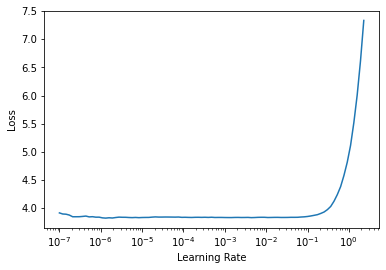

In [74]:
learner.lr_find()

In [ ]:
learn.lr_find()

Now let's follow the receipt from Jeremy Howard in his [paper](https://arxiv.org/abs/1801.06146). It is important to understand whats the difference between `fit`and `fit_one_cycle` (for that take a look [here](https://iconof.com/1cycle-learning-rate-policy/)). Also as you will see we will progressively unfreeze the layers during training, this is seen to perform better than just `fit`.

In [78]:
??learner.fit_one_cycle

In [ ]:
learner.fit_one_cycle(10, 2e-2)
learner.save('language_model')
learner.save_encoder('finetuned')

In [ ]:
learn = learn.load_encoder('finetuned')
learn.fit_one_cycle(12,  2e-3)

In [ ]:
# REFINING 1
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2))

In [ ]:
# REFINING 2
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

In [ ]:
# REFINING 3
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

In [ ]:
# Remove ShowGraphCallback Callback, it crashes with learn.predict
learner.remove_cb(ShowGraphCallback)
learn.remove_cb(ShowGraphCallback)

You can now test the language model; you can use it to create inventend sentences and see if they make sense. The more the invented sentences look like made by a person the better trained the language model.

In [43]:
learner = learner.load('language_model')

In [45]:
# For whatever reason this callback interferes with the learner.predict method, giving an error.
learner.remove_cb(ShowGraphCallback)

In [46]:
learner.predict("horrible flight", 10, temperature=0.75) 

'horrible flight experience with status match . the Exec Platinum'

## Asses model performance

In order to know if we are getting a good performance, we can compare our model training to a benchmark. We can use the IMDB dataset from fastai and see if we get a similar performance or not. 

In [76]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb = pd.read_csv(path/'texts.csv')

In [77]:
imdb.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [264]:
imdb_cls  = TextDataLoaders.from_df(imdb, text_col='text', label_col='label')
imdb_lm = TextDataLoaders.from_df(imdb, text_col='text', is_lm=True)

/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/Users/arnaujc/miniconda3/envs/fastai2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


We can compare how similar are the features of both datasets, for example we can check how many words does any review contain compared to how many words do the tweets contain.

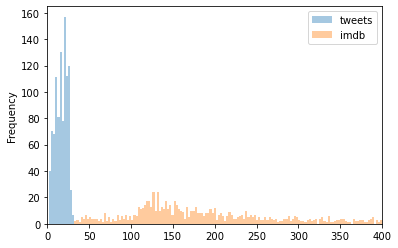

In [263]:
pd.concat([tweets.text[:1000].apply(lambda s: len(s.split())),
           imdb.text.apply(lambda s: len(s.split()))],
           axis=1,
           keys=['tweets', 'imdb']).plot.hist(alpha=0.4, bins = 500, xlim=(0,400)) 

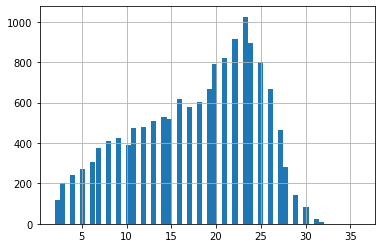

In [258]:
tweets.text.apply(lambda s: len(s.split())).hist(bins=60)

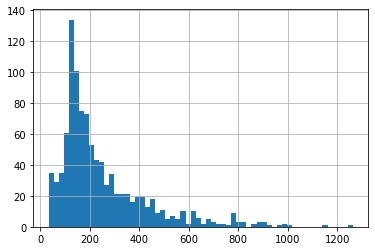

In [254]:
imdb.text.apply(lambda s: len(s.split())).hist(bins=60)

As we can see the reviews are in general much bigger than the tweets, something that is already expected but can influence the performance of the training.

Another thing to analyze is the vocabs, is the vocab from `imdb` much bigger than from the `tweets`?

In [265]:
len(lm_dls.vocab), len(imdb_lm.vocab)

(4688, 7080)

As we can see the vocab of `imdb` is almost the double as the vocab for the `tweets`, therefore it could be that the language model for the `imdb` performs better.

In order to simplify things, I will just define a function that does everything we have done so far:

In [ ]:
def complete_training(lm_dls, cl_dls, cbs=None):

    if cbs==None:
        cbs = [
              ShowGraphCallback,
              ActivationStats,
              SaveModelCallback
            ]

    learner = language_model_learner(lm_dls, AWD_LSTM, cbs = cbs,  metrics=[accuracy])
    # TRY CHANGING drop_mult, to see if there is an effect in training small datasets
    learn = text_classifier_learner(cl_dls, AWD_LSTM, drop_mult=0.5, cbs=cbs, metrics=accuracy).to_fp16()

    # ----  TRAIN THE LANGUAGE MODEL  ----
    learner.fit_one_cycle(10, 2e-2)
    # learner.save('language_model')
    learner.save_encoder('finetuned')

    # ----  TRAIN THE CLASSIFIER  ----
    learn = learn.load_encoder('finetuned')
    learn.fit_one_cycle(12,  2e-3)

    # REFINING 1
    learn.freeze_to(-2)
    learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2))

    # REFINING 2
    learn.freeze_to(-3)
    learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

    # REFINING 3
    learn.unfreeze()
    learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

    learner.remove_cb(ShowGraphCallback)
    learn.remove_cb(ShowGraphCallback)

    return learner, learn

In [ ]:
learner_imdb, learn_imdb = complete_training(imdb_lm, imdb_cls)

In [196]:
torch.randint(400, (64,72))

tensor([[ 34, 353, 223,  ..., 204,  97, 246],
        [371, 355,  64,  ..., 210, 394, 190],
        [268,  82, 281,  ..., 370, 350, 348],
        ...,
        [ 56, 309, 146,  ...,  43, 213, 121],
        [ 88, 364, 168,  ...,  75, 320, 198],
        [327, 242, 151,  ...,  60, 224, 179]])

In [188]:
text_data.one_batch()[0].size()

torch.Size([64, 72])

In [129]:
for hook in learner.activation_stats.hooks.hooks:
    print(hook.stored)

None
None
None
None
None
None
None
None
{'mean': -1.0784971714019775, 'std': 1.7559617757797241, 'near_zero': 0.7773613187474692, 'hist': tensor([6.4589e+05, 5.5320e+05, 4.6831e+05, 3.9165e+05, 3.2837e+05, 2.7821e+05,
        2.3211e+05, 1.9375e+05, 1.6353e+05, 1.3667e+05, 1.1454e+05, 9.6002e+04,
        7.9578e+04, 6.7210e+04, 5.5756e+04, 4.6225e+04, 3.8507e+04, 3.2020e+04,
        2.7027e+04, 2.2465e+04, 1.8770e+04, 1.5887e+04, 1.3319e+04, 1.1015e+04,
        9.1940e+03, 7.5300e+03, 6.1130e+03, 5.1200e+03, 4.1790e+03, 3.5160e+03,
        2.6490e+03, 2.2620e+03, 1.7800e+03, 1.4300e+03, 1.0650e+03, 7.9300e+02,
        6.1300e+02, 5.2900e+02, 3.8500e+02, 2.8100e+02])}


In [138]:
for hook in learner.activation_stats.hooks.hooks:
    print(hook.removed)

True
True
True
True
True
True
True
True
True


In [137]:
learner.activation_stats.hook

<bound method ActivationStats.hook of ActivationStats>

In [62]:
trainable_pg = {}
layers_pg = {}
for n, group in enumerate(learner.opt.param_lists):
    trainable_pg[n]= group[0].requires_grad
    layers_pg[n] = len(group)
trainable_pg, layers_pg

({0: False, 1: False, 2: False, 3: True}, {0: 4, 1: 4, 2: 4, 3: 2})

## Non-solved Issue with Hooks

So far it seems that the defautl `AWD_LSTM` arquitecture from fastai is not really working well with hooks. Let's work it out in the following example.

In [118]:
import torch 
import torch.nn as nn

def hook_fn(m, i, o):
  print(f"Working for layer: -- {m._get_name()} --")


In [173]:
for m in modules:
    m.register_forward_hook(hook_fn)

### Layers

In [85]:
modules = [m for m in flatten_model(learner.model) if has_params(m)]; modules

[Embedding(4688, 400, padding_idx=1),
 Embedding(4688, 400, padding_idx=1),
 LSTM(400, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 400, batch_first=True),
 ParameterModule(),
 Linear(in_features=400, out_features=4688, bias=True)]

In [221]:
# model = get_language_model(AWD_LSTM, 100)
model =  awd(vocab_sz=3,
                  emb_sz=5,
                  n_hid=6,
                  n_layers=2)
model.encoder.register_forward_hook(hook_fn)
model

awd(
  (encoder): Embedding(3, 5, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(3, 5, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): LSTM(5, 6, batch_first=True)
    (1): LSTM(6, 5, batch_first=True)
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
  )
)

In [222]:
for m in flatten_model(model):
    if has_params(m):
        print(m._get_name())
        m.register_forward_hook(hook_fn)
# print(model.bs ==  torch.randint(3, (1,4)).shape[0])
model.reset()
model(torch.randint(3, (1,4)))

Embedding
Embedding
LSTM
LSTM
Working for layer: -- Embedding --
Working for layer: -- Embedding --
Working for layer: -- Embedding --
Working for layer: -- LSTM --
Working for layer: -- LSTM --


tensor([[[ 0.0587,  0.1035,  0.0819, -0.0410, -0.1014],
         [ 0.1026,  0.1546,  0.1246, -0.0702, -0.1392],
         [ 0.1310,  0.1815,  0.1482, -0.0887, -0.1515],
         [ 0.1484,  0.1964,  0.1615, -0.1002, -0.1549]]],
       grad_fn=<TransposeBackward0>)

In [128]:
model(torch.randint(3, (1,4)))

tensor([[[-0.0745,  0.0718, -0.1414, -0.1269, -0.0425],
         [-0.1317,  0.0577, -0.1877, -0.2021, -0.0905],
         [-0.1637,  0.0457, -0.2116, -0.2390, -0.1234],
         [-0.1816,  0.0393, -0.2249, -0.2561, -0.1437]]],
       grad_fn=<TransposeBackward0>)

In [135]:
??to_detach

In [86]:
[m for m in flatten_model(model) if has_params(m)]

[Embedding(3, 5, padding_idx=1),
 Embedding(3, 5, padding_idx=1),
 LSTM(5, 6, batch_first=True),
 ParameterModule(),
 LSTM(6, 5, batch_first=True),
 ParameterModule()]

## IT IS THE DROPOUT!!!! IT IS NOT WORKING WITH THE HOOKS!

In [220]:
class awd(Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182"
    initrange=0.1

    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False):
        store_attr('emb_sz,n_hid,n_layers,pad_token')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, inp, from_embeds=False):
        bs,sl = inp.shape

#         output = self.encoder (inp)
        output = self.input_dp(self.encoder(inp))
#        AVOIDS FORWARDS_HOOKS FOR EMBBED -> It is the encoder_dp
#         output = self.input_dp(self.encoder_dp(inp))
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            output, _ = rnn(output, self.hidden[l])
            if l != self.n_layers - 1: output = hid_dp(output)
        return output

    def _one_rnn(self, n_in, n_out, bidir, weight_p, l):
        "Return one of the inner rnn"
        rnn = nn.LSTM(n_in, n_out, 1, batch_first=True)
#         AVOIDS FORWARD_HOOKS FOR RNN
#         return WeightDropout(rnn, weight_p)
        return rnn

    def _one_hidden(self, l):
        "Return one hidden state"
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return (one_param(self).new_zeros(self.n_dir, self.bs, nh), one_param(self).new_zeros(self.n_dir, self.bs, nh))

    def _change_one_hidden(self, l, bs):
        if self.bs < bs:
            nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
            return tuple(torch.cat([h, h.new_zeros(self.n_dir, bs-self.bs, nh)], dim=1) for h in self.hidden[l])
        if self.bs > bs: return (self.hidden[l][0][:,:bs].contiguous(), self.hidden[l][1][:,:bs].contiguous())
        return self.hidden[l]

    def reset(self):
        "Reset the hidden states"
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]

In [123]:
bs=64
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [125]:
lmmodel = LMModel7(5,2, 1, p=0.1)
for m in flatten_model(lmmodel):
    if has_params(m):
        print(m._get_name())
        m.register_forward_hook(hook_fn)

Embedding
LSTM
Linear


In [126]:
lmmodel(torch.randint(5, (64,5)))

Working for layer: -- Embedding --
Working for layer: -- LSTM --
Working for layer: -- Linear --


(tensor([[[ 4.8395e-01, -5.1640e-01,  6.1054e-01, -2.0308e-02, -9.3443e-01],
          [ 4.3933e-01, -5.8131e-01,  6.1733e-01, -7.4054e-02, -1.0070e+00],
          [ 4.2293e-01, -6.1924e-01,  6.2065e-01, -1.0316e-01, -1.0216e+00],
          [ 4.2007e-01, -6.2445e-01,  6.2114e-01, -1.0730e-01, -1.0254e+00],
          [ 4.9134e-01, -4.8462e-01,  6.0819e-01,  2.5667e-03, -9.4050e-01]],
 
         [[ 4.8990e-01, -4.8656e-01,  6.0840e-01,  9.3740e-04, -9.4298e-01],
          [ 4.3532e-01, -6.0054e-01,  6.1872e-01, -8.7787e-02, -1.0020e+00],
          [ 4.3759e-01, -5.8244e-01,  6.1751e-01, -7.5218e-02, -1.0111e+00],
          [ 4.2285e-01, -6.1841e-01,  6.2060e-01, -1.0263e-01, -1.0226e+00],
          [ 6.6006e-01, -2.0128e-01,  5.8032e-01,  2.3099e-01, -6.9853e-01]],
 
         [[ 6.4582e-01, -2.3694e-01,  5.8336e-01,  2.0391e-01, -7.0887e-01],
          [ 4.6919e-01, -5.1824e-01,  6.1164e-01, -2.5042e-02, -9.7535e-01],
          [ 4.3655e-01, -5.7787e-01,  6.1732e-01, -7.2433e-02, -1.0180

In [65]:
for m in flatten_model(model):
    if has_params(m):
        m.register_forward_hook(hook_fn)

In the following examples the hooks work well

In [69]:
class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(3,10,2, stride = 2)
    self.relu = nn.ReLU()
    self.flatten = lambda x: x.view(-1)
    self.fc1 = nn.Linear(160,5)
   
  def forward(self, x):
    x = self.relu(self.conv(x))
    return self.fc1(self.flatten(x))

net = myNet()

net.conv.register_forward_hook(hook_fn)
net.fc1.register_forward_hook(hook_fn)
inp = torch.randn(1,3,8,8)
out = net(inp)


How working for layer: -- Conv2d --
How working for layer: -- Linear --


In [176]:
learner.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4688, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4688, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4688, bias=True)
    (output_dp): RNNDropout()
  )
)

In [126]:
learner.activation_stats.modules

[Embedding(4688, 400, padding_idx=1),
 Embedding(4688, 400, padding_idx=1),
 LSTM(400, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 400, batch_first=True),
 ParameterModule(),
 Linear(in_features=400, out_features=4688, bias=True)]

In [150]:
type(modules[2])

torch.nn.modules.rnn.LSTM

epoch,train_loss,valid_loss,time
0,5.978067,5.422278,07:00


Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

Linear(in_features=400, out_features=4688, bias=True)
------------Input Grad------------
torch.Size([64, 72, 400])
------------Output Grad------------
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688])
torch.Size([72, 4688]

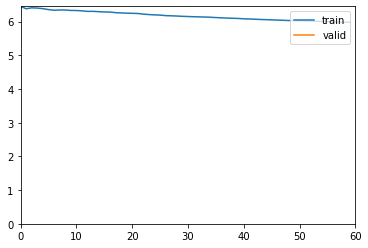

KeyboardInterrupt: 

In [148]:
learner.fit_one_cycle(1)
# learner.fine_tune()
# learner.fit(1)

In [145]:
learner.cbs[5].stats[0]

(#9) [None,None,None,None,None,None,None,None,{'mean': -2.0935938358306885, 'std': 1.3332597017288208, 'near_zero': 0.931707408916159}]

We can not plot the statistics of the weights for each layer:

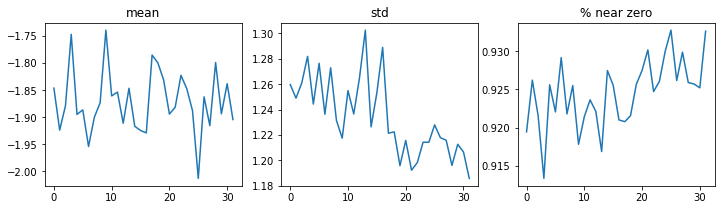

In [157]:
learner.activation_stats.plot_layer_stats(8)

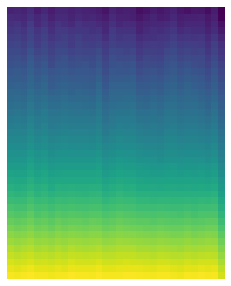

In [156]:
learner.activation_stats.color_dim(8)

We can do this because we used a Callback/Hook named ActivationStats that keeps track of the statistics while training.

For some reason the statistics are just recorded for the last layer of the model. As we can see the first 8 layers just give the value None:

In [ ]:
list(learn_tweets.activation_stats.stats[0])

In [151]:
learner.activation_stats.stats[0]

(#9) [None,None,None,None,None,None,None,None,{'mean': -1.8462823629379272, 'std': 1.2596983909606934, 'near_zero': 0.9194439246831189, 'hist': tensor([1.2411e+06, 1.0021e+06, 8.0230e+05, 6.4066e+05, 5.0985e+05, 4.0494e+05,
        3.2018e+05, 2.5357e+05, 2.0129e+05, 1.5805e+05, 1.2631e+05, 1.0001e+05,
        8.0982e+04, 6.4612e+04, 5.2268e+04, 4.2857e+04, 3.4609e+04, 2.8632e+04,
        2.3751e+04, 1.9741e+04, 1.6459e+04, 1.3934e+04, 1.1901e+04, 1.0163e+04,
        8.5460e+03, 7.2550e+03, 6.3900e+03, 5.4860e+03, 4.8030e+03, 4.0000e+03,
        3.4060e+03, 2.9320e+03, 2.6210e+03, 2.2900e+03, 1.9420e+03, 1.6760e+03,
        1.4160e+03, 1.2110e+03, 1.0560e+03, 8.4500e+02])}]

In [49]:
learner.__dict__

{'init_args': {'TextLearner.__init__.alpha': 2.0,
  'TextLearner.__init__.beta': 1.0,
  'TextLearner.__init__.moms': (0.8, 0.7, 0.8),
  'TextLearner.__init__.loss_func': FlattenedLoss of CrossEntropyLoss(),
  'TextLearner.__init__.lr': 0.001,
  'TextLearner.__init__.splitter': <function fastai.text.models.awdlstm.awd_lstm_lm_split(model)>,
  'TextLearner.__init__.metrics': None,
  'TextLearner.__init__.path': Path('/Users/arnaujc/Projects/kaggle/data'),
  'TextLearner.__init__.model_dir': 'models',
  'TextLearner.__init__.wd': None,
  'TextLearner.__init__.wd_bn_bias': False,
  'TextLearner.__init__.train_bn': True,
  'Learner.__init__.loss_func': FlattenedLoss of CrossEntropyLoss(),
  'Learner.__init__.lr': 0.001,
  'Learner.__init__.splitter': <function fastai.text.models.awdlstm.awd_lstm_lm_split(model)>,
  'Learner.__init__.metrics': None,
  'Learner.__init__.path': Path('/Users/arnaujc/Projects/kaggle/data'),
  'Learner.__init__.model_dir': 'models',
  'Learner.__init__.wd': None,

In [134]:
learner.model[0].encoder.weight

Parameter containing:
tensor([[ 6.0867e-01, -5.2552e-01,  1.5330e-01,  ..., -2.5346e-01,
         -3.3278e-01, -6.8334e-02],
        [-4.5477e-01,  8.9764e-02, -8.1741e-02,  ..., -1.9039e-03,
          4.9093e-01,  4.6553e-02],
        [-1.1224e-01, -3.2417e-01,  1.5993e-04,  ...,  5.1675e-02,
         -1.7925e-01,  4.2092e-01],
        ...,
        [ 2.5333e-02,  2.5912e-03,  4.2268e-02,  ...,  1.2799e-02,
          8.4781e-02, -1.8249e-03],
        [ 2.5333e-02,  2.5912e-03,  4.2268e-02,  ...,  1.2799e-02,
          8.4781e-02, -1.8249e-03],
        [ 2.5333e-02,  2.5912e-03,  4.2268e-02,  ...,  1.2799e-02,
          8.4781e-02, -1.8249e-03]], requires_grad=True)